# Wave Equation Neural Network incorporating Spatial Dependence

Add complexity to the neural network to see how it performs. Aiming to solve the 1D wave equation:

\begin{align*}
\frac{\partial^2 y}{\partial t^2}  = c^2 \frac{\partial^2 y}{\partial x^2}
\end{align*}

using the feed-forward neural network from the DHO solution. By using the appropriate boundary conditions, this equation describes a fixed string starting from rest $\left(\dot{y} \left(x, 0\right) = 0\right)$ with some initial profile, $y_0(x)$, the full solution to which is:

\begin{align*}
y\left(x, t \right) = \sum_{n=1}^{\infty}{b_n\cos{\left(\frac{cn\pi}{L} t\right)}\sin{\left(\frac{n\pi}{L} x\right)}}
\end{align*}

where the string is fixed at $y=0$ for $x=0$ and $x=L$ $\left(y \left(0, t\right) = y\left(L, t \right) = 0\right)$, $n$ is the mode number, $c$ is the wave speed, and the $b_n$ are the sine fourier coefficients for a periodic function of period $2L$ and are determined by the initial profile $y_0$. This script will focus on excitation of the first mode where $b_n = 0$ for $n\neq 1$ and $b_1 = A$, where $A$ is the amplitude of the wave. Thus the function being approximated is:

\begin{align*}
y\left(x, t\right) = A\cos{\left(\frac{c \pi}{L} t\right)} \sin{\left(\frac{\pi x}{L}\right)}
\end{align*}

In [64]:
import torch as t
import numpy as np 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
import random

(1000, 1000)


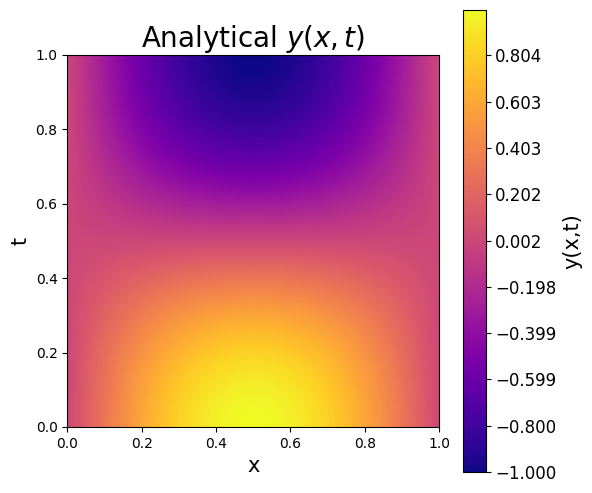

In [ ]:
def analytical(t, x, c, L, A):
    """t- Time array, x- Position array, c- wave speed, L- Length of string, A- Amplitude"""
    k = np.pi/L
    return A*np.cos(c*k*t)*np.sin(k*x)

time = np.linspace(0, 1, 1000)
space = np.linspace(0, 1, 1000)

y_analytical = []
for ti in time:
    ti_sol = analytical(ti, space, 1, 1, 1)
    y_analytical.append(ti_sol)

y_analytical = np.array(y_analytical)
print(y_analytical.shape)

plt.figure(figsize=(6, 6))
plt.contourf(space, time, y_analytical, levels=np.linspace(np.min(y_analytical),np.max(y_analytical),500), cmap=plt.cm.plasma)
plt.xlabel('x', fontsize = 15)
plt.ylabel('t', fontsize = 15)
plt.title(r'Analytical $y(x,t)$', fontsize = 20)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize = 12)
cbar.set_label(label='y(x,t)', size=15)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.show()

Plot follows BCs and ICs well as well as the time evolution you'd expect from the symmetry of the system.

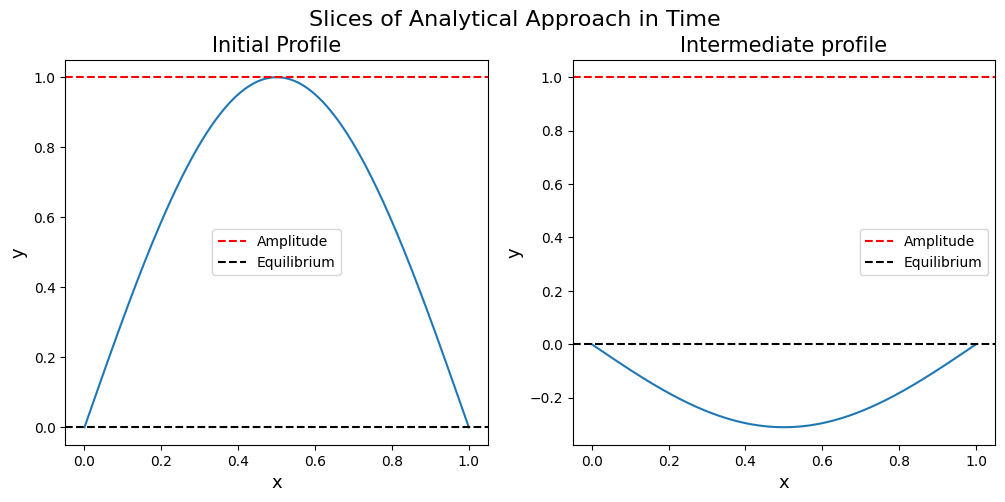

In [96]:
#Slice heat map in time
initial = y_analytical[0]
slice = y_analytical[600]

plt.figure(figsize = [12, 5])
plt.suptitle('Slices of Analytical Approach in Time', fontsize = 16)
plt.subplot(1, 2, 1)
plt.plot(space, initial)
plt.title('Initial Profile', fontsize = 15)
plt.axhline(1, linestyle = '--', color = 'r', label = 'Amplitude')
plt.axhline(0, linestyle = '--', color = 'k', label = 'Equilibrium')
plt.xlabel('x', fontsize = 13)
plt.ylabel('y', fontsize = 13)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(space, slice)
plt.title('Intermediate profile', fontsize = 15)
plt.axhline(1, linestyle = '--', color = 'r', label = 'Amplitude')
plt.axhline(0, linestyle = '--', color = 'k', label = 'Equilibrium')
plt.xlabel('x', fontsize = 13)
plt.ylabel('y', fontsize = 13)
plt.legend()
plt.show()



In [ ]:
#Create Neural Network architecture
class Model(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, num_hidden_layers=2):
        super().__init__() 
        self.input_layer = nn.Linear(in_channels, hidden_channels)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_channels, hidden_channels) for _ in range(num_hidden_layers)]) 
        self.output_layer = nn.Linear(hidden_channels, out_channels) 

    def forward(self, x: t.tensor):
        #x is a tensor with shape [batch_size, in_channels]
        x = F.tanh(self.input_layer(x)) 
        #x leaves as tensor with shape [batch_size, hidden_channels]
        for hidden_layer in self.hidden_layers:
            x = F.sigmoid(hidden_layer(x))
        #x leaves as tensor with shape [batch_size, output_channels]
        x = self.output_layer(x) 
        return x 

In [97]:
#Define loss and optimiser
learning_rate = 1e-2
model = Model(2, 1, 32)